In [15]:
import tensorflow as tf

In [16]:
# Import required python library
import numpy as np
# from tensorflow.keras.models import Sequential
# from keras.layers.core import Dense, Activation
# from keras.layers.recurrent import SimpleRNN
# from keras.layers.recurrent import LSTM
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

# def weights(shape):
#     return np.random.normal(scale=.01, size=shape)
def weights(shape, dtype=None):
  return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

# def bias(shape, dtype=None):
#   return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def train_rnn(df, model_type, T, T_predict, BPTT, hidden_n, train_n, 
              batch_size, iter_n, learning_rate, adam_beta1, adam_beta2):
    
    N = T + T_predict
    f = df.values[0:(N+1)]
    
    data = []
    target = []
    for i in range(0, N - BPTT + 1):
        data.append(f[i: i + BPTT])
        target.append(f[i + BPTT])

    X = np.array(data).reshape(len(data), BPTT, 1)
    Y = np.array(target).reshape(len(data), 1)

    N_train = int(len(data) * train_n)
    N_test = len(data) - N_train

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=N_test)

    n_in = len(X[0][0])
    n_out = len(Y[0])
    
    model = tf.keras.Sequential()
    if( model_type == "lstm" ):
        model.add(tf.keras.layers.LSTM(hidden_n,
                    init=weights,
                    input_shape=(BPTT, n_in)))
    else:
        model.add(tf.keras.layers.SimpleRNN (hidden_n,
                    kernel_initializer=weights,
                    input_shape=(BPTT, n_in)))


    model.add(tf.keras.layers.Dense(n_out, kernel_initializer=weights,activation='linear'))
    # model.add(Activation('linear'))

    # opt = Adam(lr=learning_rate, beta_1=adam_beta1, beta_2=adam_beta2)
   
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=learning_rate, beta_1=adam_beta1, beta_2=adam_beta2))

    results = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=iter_n,
          validation_data=(X_test, Y_test))

    truncate = BPTT
    Z = X[:1]
    original = [f[i] for i in range(BPTT)]
    predicted = [None for i in range(BPTT)]
    for i in range(N - BPTT + 1):
        z_ = Z[-1:]
        y_ = model.predict(z_)
        sequence_ = np.concatenate(
            (z_.reshape(BPTT, n_in)[1:], y_),
            axis=0).reshape(1, BPTT, n_in)
        Z = np.append(Z, sequence_, axis=0)
        predicted.append(y_.reshape(-1))

    d = {'loss_train' : pd.Series(results.history['loss']),
          'loss_test' : pd.Series(results.history['val_loss']),
          'original' : pd.Series(original),
          'predicted' : pd.Series(predicted)}

    return(pd.DataFrame(d))

1000
9/9 [==============================] - 0s 17ms/sample - loss: 1.2101e-14 - val_loss: 0.1729
Epoch 815/1000
9/9 [==============================] - 0s 16ms/sample - loss: 1.2225e-14 - val_loss: 0.1729
Epoch 816/1000
9/9 [==============================] - 0s 16ms/sample - loss: 9.3752e-15 - val_loss: 0.1729
Epoch 817/1000
9/9 [==============================] - 0s 16ms/sample - loss: 3.1148e-14 - val_loss: 0.1729
Epoch 818/1000
9/9 [==============================] - 0s 16ms/sample - loss: 1.3261e-14 - val_loss: 0.1729
Epoch 819/1000
9/9 [==============================] - 0s 16ms/sample - loss: 3.7637e-14 - val_loss: 0.1729
Epoch 820/1000
9/9 [==============================] - 0s 16ms/sample - loss: 4.8233e-15 - val_loss: 0.1729
Epoch 821/1000
9/9 [==============================] - 0s 17ms/sample - loss: 2.0317e-14 - val_loss: 0.1729
Epoch 822/1000
9/9 [==============================] - 0s 17ms/sample - loss: 3.4355e-14 - val_loss: 0.1729
Epoch 823/1000
9/9 [===========================

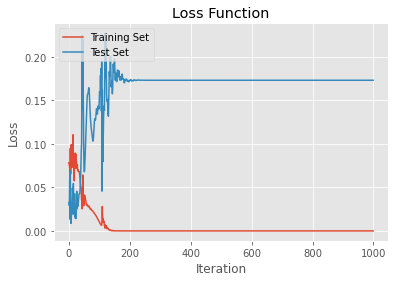

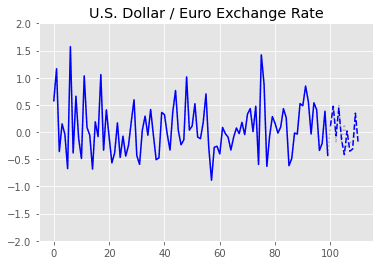

In [17]:
# Import required python library
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from pandas_datareader import data
import datetime
# from rnn_func import train_rnn

# Use ggplot style
style.use('ggplot')

# Set model parameters
model_type="simple"	# model type = "simple" or "lstm"
T = 100			# the period of original data
BPTT = 100		# the period of BPTT (backpropagation through time)
T_predict = 10		# the period of model prection
hidden_n = 20		# the number of hidden layers
iter_n = 1000		# the number of iterations
train_n = 0.9		# the proportion of training set
batch_size = 10		# batch size
learning_rate = 0.01	# learning rate
adam_beta1 = 0.9	# Adam (adaptive moment estimation) parameter 1
adam_beta2 = 0.999	# Adam (adaptive moment estimation) parameter 2

# web scraping USD/EURO FX
tickers = ['DEXUSEU']
data_source = 'fred'
start_date = '2017-01-01'
end_date = datetime.date.today()
df = data.DataReader(tickers, data_source, start_date, end_date)
df= df[df.DEXUSEU.notnull()]	# drop NA
df= df.pct_change()*100         # calculate the percentage changes
df= df[df.DEXUSEU.notnull()]	# drop NA

# Run RNN model
results = train_rnn(df, model_type, T, T_predict, BPTT, hidden_n, train_n, 
                    batch_size, iter_n, learning_rate, adam_beta1, adam_beta2)

# Plotting loss function
plt.plot(results['loss_train'])
plt.plot(results['loss_test'])
plt.title('Loss Function')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Training Set', 'Test Set'], loc='upper left')
plt.show()

# Plotting forecasts
plt.figure()
plt.title("U.S. Dollar / Euro Exchange Rate")
plt.ylim([-2.0, 2.0])
plt.plot(df.values[0:(T+T_predict+1)], linestyle='dotted', color='#aaaaaa')
plt.plot(results['original'], color='blue')
plt.plot(results['predicted'], linestyle='dashed', color='blue')
plt.show()